In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from io import StringIO
import glob
import os
import raytracing as rt
from scipy.ndimage import gaussian_filter
from scipy.stats import linregress
from scipy.optimize import curve_fit

import scipy.optimize as spo
import scipy.constants as spc
import scipy.integrate as spi
import scipy.linalg as spl
import scipy.signal as spsi
import scipy.stats as spst

In [24]:
def lire_csv(chemin_fichier):
    """
    Lecture d'un fichier CSV avec une première ligne à ignorer,
    et renvoie un DataFrame pandas.

    Args:
        chemin_fichier (str): Le chemin d'accès vers le fichier CSV.

    Returns:
        pandas.DataFrame: Un DataFrame pandas contenant les données du fichier CSV.
    """
    # Lire le fichier en ignorant la première ligne
    with open(chemin_fichier, 'r', encoding='utf-8') as fichier:
        lignes = fichier.readlines()[1:]  # Ignorer la première ligne
    
    # Préparer le contenu transformé
    contenu_transforme = []
    for ligne in lignes:
        partie_gauche, _, partie_droite = ligne.partition(', ')  # Séparer à la première virgule
        partie_gauche, partie_droite = partie_gauche.replace(',', '.'), partie_droite.replace(',', '.')   # Au cas où, mais devrait être inutile ici
        ligne_transformee = partie_gauche + ';' + partie_droite
        contenu_transforme.append(ligne_transformee)
    
    # Convertir le contenu transformé en un objet StringIO
    contenu_csv = StringIO(''.join(contenu_transforme))
    
    # Lire le contenu transformé en DataFrame
    df = pd.read_csv(contenu_csv, names=['Pixels', 'Value'],sep=";")
    return df

# Données partie 3

In [25]:
# Partie 3 a
df_partie_3a = pd.read_excel("Projet_final.xlsx", sheet_name="Partie 3a")

p3a_ms = df_partie_3a["ms"][1:]
p3a_shutter_speed = df_partie_3a["shutter speed (fps)"][1:]
p3a_mu = df_partie_3a["mu (ln(I_0/I))"][1:]
p3a_sigma = df_partie_3a["sigma"][1:]

# Partie 3 b
df_partie_3b = pd.read_excel("Projet_final.xlsx", sheet_name="Partie 3b")

p3b_bruit = df_partie_3b["bruit (%)"][1:8]
p3b_mu_B = df_partie_3b["mu_B"][1:8]
p3b_sigma_B = df_partie_3b["sigma_B"][1:8]
p3b_cone_clair_mu = df_partie_3b["Cône clair"][1:8]
p3b_cone_clair_cnr = df_partie_3b["Unnamed: 5"][1:8]
p3b_cone_sombre_mu = df_partie_3b["Cöne sombre"][1:8]
p3b_cone_sombre_cnr = df_partie_3b["Unnamed: 8"][1:8]

In [26]:
# Propagation incertitudes partie 3 a
diametre_cylindre = 7
incertitude_cylindre = 0.2

def propagation_incertitudes_division_liste(mesures, incertitudes, diviseur, incertitude_diviseur):
    resultats = []
    incertitudes_resultats = []
    for mesure, incertitude in zip(mesures, incertitudes):
        resultat = mesure / diviseur
        incertitude_resultat = resultat * np.sqrt((incertitude / mesure)**2 + (incertitude_diviseur / diviseur)**2)
        resultats.append(resultat)
        incertitudes_resultats.append(incertitude_resultat)
    return resultats, incertitudes_resultats

mu_2d, sigma_2d = propagation_incertitudes_division_liste(p3a_mu, p3a_sigma, diametre_cylindre, incertitude_cylindre)


snr = [(1 / np.exp(x)) / y for x, y in zip(mu_2d, p3a_sigma)]


erreur_3a = [ ((1 / (y * np.exp(x))) * (np.sqrt((y / x)**2))) * (750 / z) for x, y, z in zip(p3a_mu, p3a_sigma, snr)]


       


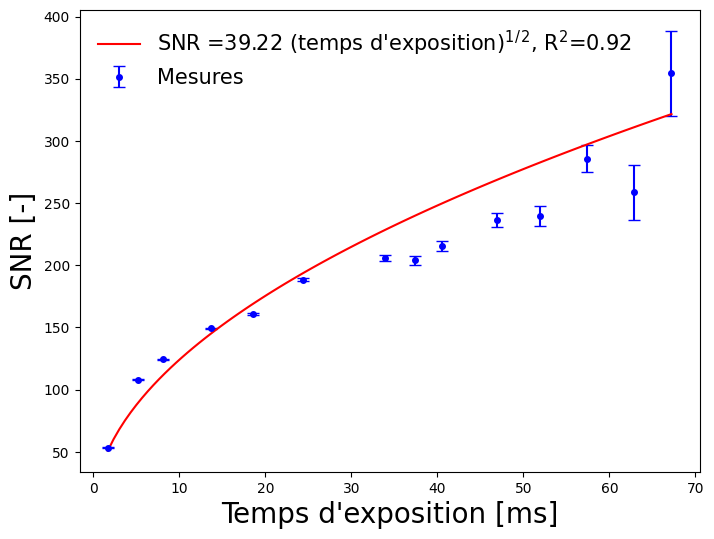

In [27]:
# Graphique 3a

# Affichage
plt.figure(figsize=(8, 6))

plt.errorbar(p3a_ms, snr, yerr= erreur_3a, color='blue', marker='o', markersize=4, capsize=4, linestyle='', label='Mesures')

def modele(x, a):
    return a * np.sqrt(x)

# Ajustement du modèle aux données
params, covariance = curve_fit(modele, p3a_ms, snr, sigma=sigma_2d)
a = params[0]

# Courbe de régression
x_range = np.linspace(min(p3a_ms), max(p3a_ms), 100)
y_fit = modele(x_range, a)

# Coefficient de détermination R^2
slope, intercept, r_value, _, _ = linregress(snr, modele(p3a_ms, a))
r_squared = r_value ** 2

plt.plot(x_range, y_fit, color='red', label=f"SNR ={a:.2f} (temps d'exposition)$^1$$^/$$^2$, R$^2$={r_squared:.2f}")



plt.xlabel("Temps d'exposition [ms]", fontsize=20)
plt.ylabel("SNR [-]", fontsize=20)
plt.legend(frameon=False, fontsize=15)
plt.show()

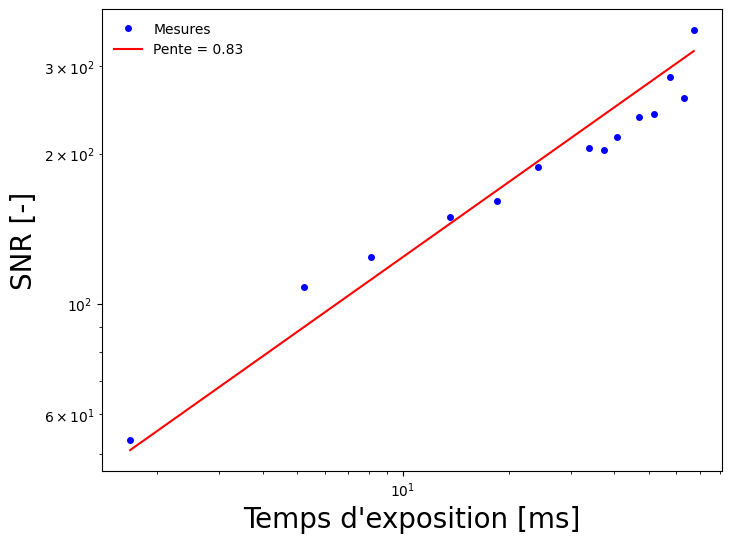

In [28]:
plt.figure(figsize=(8, 6))

plt.loglog(p3a_ms, snr, color='blue', marker='o', markersize=4, linestyle='', label='Mesures')

def modele(x, a):
    return a * np.sqrt(x)

# Ajustement du modèle aux données
params, covariance = curve_fit(modele, p3a_ms, snr, sigma=sigma_2d)
a = params[0]

# Courbe de régression
x_range = np.linspace(min(p3a_ms), max(p3a_ms), 100)
y_fit = modele(x_range, a)

# Coefficient de détermination R^2
slope, intercept, r_value, _, _ = linregress(snr, modele(p3a_ms, a))
r_squared = r_value ** 2


def calculate_slope(x1, y1, x2, y2):
    # Calculer les logarithmes des coordonnées
    log_y1 = np.log(y1)
    log_y2 = np.log(y2)
    log_x1 = np.log(x1)
    log_x2 = np.log(x2)
    
    # Calculer la pente
    slope = (log_y2 - log_y1) / (log_x2 - log_x1)
    
    return slope

m = calculate_slope(x_range[1], x_range[8], y_fit[1], y_fit[8])

plt.loglog(x_range, y_fit, color='red', label=f"Pente = {m:.2f}")


plt.xlabel("Temps d'exposition [ms]", fontsize=20)
plt.ylabel("SNR [-]", fontsize=20)
plt.legend(frameon=False, fontsize=10)
plt.show()

In [30]:
# Calcul CNR et propagation données
delta_a_clair = [0.0191,0.0218,0.0176,0.0223,0.0364,0.0567,0.0452]
CNR_cone_clair = []
erreur_cone_clair = []

for ai, bi, ci, delta_ai in zip(p3b_cone_clair_mu, p3b_mu_B, p3b_sigma_B, delta_a_clair):
    resultat = (ai - bi) / ci
    incertitude_propagee = delta_ai / ci
    CNR_cone_clair.append(resultat)
    erreur_cone_clair.append(incertitude_propagee)

delta_a_sombre = [0.0191,0.0218,0.0176,0.0223,0.0364,0.0567,0.0452]
CNR_cone_sombre = []
erreur_cone_sombre = []

for ai, bi, ci, delta_ai in zip(p3b_cone_sombre_mu, p3b_mu_B, p3b_sigma_B, delta_a_sombre):
    resulta = (ai - bi) / ci
    incertitude_propage = delta_ai / ci
    CNR_cone_sombre.append(resulta)
    erreur_cone_sombre.append(incertitude_propage)


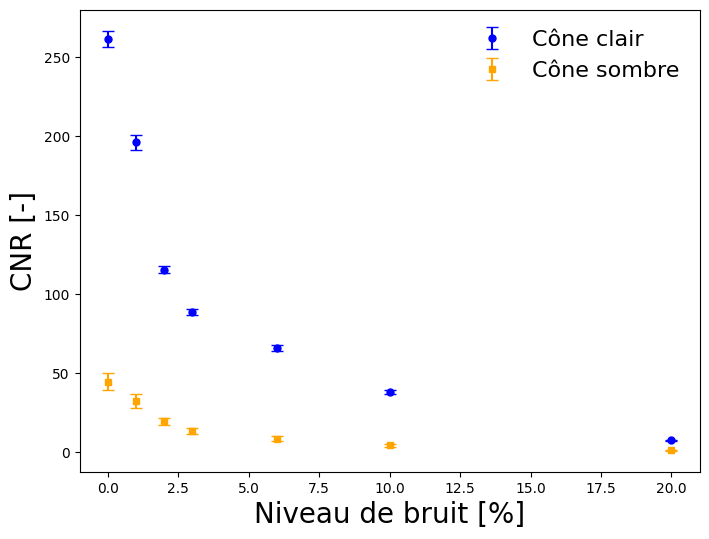

In [31]:
# Graphique 3b

plt.figure(figsize=(8, 6))

plt.errorbar(p3b_bruit, CNR_cone_clair, yerr=erreur_cone_clair, color = 'blue', marker='o', markersize=5, capsize=4, linestyle = '', label='Cône clair')
plt.errorbar(p3b_bruit, CNR_cone_sombre, yerr=erreur_cone_sombre, color ='orange', marker='s', markersize=5, capsize=4, linestyle = '', label='Cône sombre')



plt.xlabel("Niveau de bruit [%]",fontsize=20)
plt.ylabel("CNR [-]", fontsize=20)
plt.legend(frameon=False, fontsize=16)



plt.show()